【Task4(2天)】用PyTorch实现多层网络   
1.引入模块，读取数据   
2.构建计算图（构建网络模型）  
3.损失函数与优化器  
4.开始训练模型  
5.对训练的模型预测结果进行评估  

### 1.引入模块，读取数据

torch.Size([60000, 28, 28])
torch.Size([60000])


D:\MyCodeEnvironment\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\MyCodeEnvironment\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


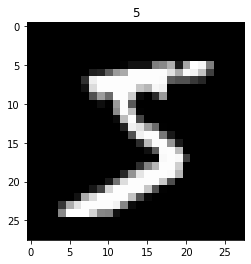

D:\MyCodeEnvironment\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\MyCodeEnvironment\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [1]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
 
 
# torch.manual_seed(1)    # reproducible
 
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height  每次读一行像素点，一共28行，就有28个时间点
INPUT_SIZE = 28         # rnn input size / image width  每行有28个像素点 所以输入信息为28 
LR = 0.01               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data
 
 
# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)
 
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
 
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

### 2.构建计算图（构建网络模型）
利用一个类来建立模型， 这里我们要建立的是RNN模型

In [2]:
 
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
 
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit  64个神经元
            num_layers=1,           # number of rnn layer  一层神经元（比较简单）
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )                           #if (time_step, batch, input_size)   batch_first=False
 
        self.out = nn.Linear(64, 10)  # 64：神经元的输出做输入  10:10个分类作为输出 
 
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state
 
        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])  #(batch,time_step,input) 选取看完整张图片之后的时间点，再进行训练
        return out
 
 
rnn = RNN()
print(rnn)
 

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


### 3.损失函数与优化器

In [3]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted 数字标签是多少就是多少
                                                       #比如数字标签是7 ，不会显示0111

### 4.开始训练模型

In [4]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
 
        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
 
        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3001 | test accuracy: 0.10
Epoch:  0 | train loss: 1.0671 | test accuracy: 0.55
Epoch:  0 | train loss: 0.6995 | test accuracy: 0.72
Epoch:  0 | train loss: 0.7373 | test accuracy: 0.78
Epoch:  0 | train loss: 0.4621 | test accuracy: 0.86
Epoch:  0 | train loss: 0.1884 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2303 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3460 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1686 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1696 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1458 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2347 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2156 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1815 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0892 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1815 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0720 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0824 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1699 | test accuracy

### 5.对训练的模型预测结果进行评估

In [6]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
